# 00X.00X XXX - Stepping thru Season Predictions

In [1]:
import pathlib
import sys
import joblib

import pandas as pd
import numpy as np
import missingno as msno

# import scipy.stats as stats
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from scipy.stats import poisson, nbinom


import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload all modules
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import get_model_diagnosis
from src.visualization.visualize import extend_cols
from src.data.transform_long_to_wide import run_transform_ts_to_supervised
from src.data.transformed_to_all_stacked import transformed_to_all_stacked
from src.data.stacked_to_ts_featured import clean_df
from src.models.metrics import insert_rps
from src.betting.simulate import simulate_betting

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SAMPLE_DIR = PROJECT_DIR / 'data' / 'sample'
SAMP_STACKED_DIR = SAMPLE_DIR / '01-stacked-seasons'
SAMP_FEATURED_DIR = SAMPLE_DIR / '02-featured'
SAMP_TRANSFORMED_DIR = SAMPLE_DIR / '03-transformed'

# fn = '2007-2008__2017-2018.csv'
# EDA_FP = SAMPLE_DIR / '01-stacked-seasons' / 'germany' / 'bundesliga' / fn
# SAVED_IMAGES_DIR = PROJECT_DIR / 'notebooks' / 'saved-images'

fn = '2007-2008__2017-2018.csv'
SAMP_STACKED_FP = SAMP_STACKED_DIR / 'germany' / 'bundesliga' / fn
SAMP_FEATURED_FP = SAMP_FEATURED_DIR / 'germany' / 'bundesliga' / fn
SAMP_TRANSFORMED_FP = SAMP_TRANSFORMED_DIR / 'germany' / 'bundesliga' / fn
SAMP_MODEL_FP = SAMPLE_DIR / 'models' / 'optimized-model.joblib'
SAMP_CAL_FP = SAMPLE_DIR / 'models' / 'calibration-model.joblib'
SAVE_FP = SAMPLE_DIR / 'check-output' / 'test.csv'

In [36]:
df_orig = pd.read_csv(SAVE_FP, index_col=None, parse_dates=['date'])
df_orig.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,1,2,3,pred_class,pred_result,model_rps,bookie_rps,baseline_rps,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,placed_bet,game_ret
0,germany,bundesliga,2016-2017,ingolstadt,rb-leipzig,2016-12-10,1.0,0.0,hwin,4.0,16.0,0.0,0.253204,0.219288,0.527508,0.154623,0.072617,0.772724,0.0,13.0,3.0,4.0,1.80,1.75,1.85,1.80,0.275,0.275,0.45,3.75,3.75,3.75,3.63,3.0,19.0,1.0,0.253204,0.527508,0.219288,0.154623,0.772724,0.072617,1.0,4.0,1.0,1.0,4.33,4.75,5.00,4.62,0.527508,0.253204,0.219288,1,1,0,0,0.405229,0.611111,0.473198,0.231347,0.295455,1,hwin,0.182407,0.443889,0.189062,1.186174,-0.160210,-0.468181,True,False,False,4.00,0.0,0.0,hwin_bet,4.00
1,germany,bundesliga,2016-2017,borussia-monchengladbach,mainz,2016-12-11,1.0,0.0,hwin,1.0,15.0,0.0,0.238367,0.570939,0.190694,0.231480,0.353203,0.415314,1.0,12.0,4.0,0.0,5.00,5.00,5.35,4.86,0.275,0.275,0.45,4.00,3.70,4.06,3.85,4.0,13.0,0.0,0.238367,0.190694,0.570939,0.231480,0.415314,0.353203,0.0,9.0,3.0,2.0,1.67,1.72,1.85,1.71,0.190694,0.238367,0.570939,1,1,0,0,0.411765,0.611111,0.666234,0.231566,0.102200,1,hwin,0.060922,0.110229,0.189062,0.139260,-0.108470,-0.503308,True,False,False,0.85,0.0,0.0,hwin_bet,0.85
2,germany,bundesliga,2016-2017,hoffenheim,dortmund,2016-12-16,2.0,2.0,draw,4.0,18.0,1.0,0.237260,0.249747,0.512994,0.227446,0.445892,0.326659,1.0,14.0,4.0,1.0,1.85,1.91,2.04,1.91,0.275,0.275,0.45,4.00,4.10,4.10,3.92,2.0,22.0,2.0,0.237260,0.512994,0.249747,0.227446,0.326659,0.445892,0.0,13.0,5.0,5.0,3.80,3.75,4.30,3.74,0.512994,0.237260,0.249747,2,0,1,0,0.415033,1.000000,0.352755,0.225244,0.422001,3,awin,0.151261,0.162768,0.139062,0.319303,-0.117045,-0.193977,True,False,False,-1.00,0.0,0.0,hwin_bet,-1.00
3,germany,bundesliga,2016-2017,schalke,sc-freiburg,2016-12-17,1.0,1.0,draw,1.0,9.0,0.0,0.238367,0.570939,0.190694,0.216683,0.621707,0.161605,0.0,6.0,2.0,0.0,5.00,5.25,5.50,5.16,0.275,0.275,0.45,4.00,4.00,4.15,3.90,9.0,12.0,0.0,0.238367,0.190694,0.570939,0.216683,0.161605,0.621707,0.0,17.0,2.0,1.0,1.67,1.65,1.77,1.67,0.190694,0.238367,0.570939,2,0,1,0,0.434641,1.000000,0.566038,0.243224,0.190738,1,hwin,0.178390,0.181168,0.139062,-0.054717,-0.051428,-0.015790,False,False,False,0.00,0.0,0.0,no_bet,0.00
4,germany,bundesliga,2016-2017,wolfsburg,eintracht-frankfurt,2016-12-17,1.0,0.0,hwin,2.0,18.0,0.0,0.298805,0.382470,0.318725,0.283842,0.165794,0.550365,0.0,7.0,1.0,4.0,3.00,2.95,3.10,2.95,0.275,0.275,0.45,3.20,3.30,3.32,3.21,4.0,17.0,1.0,0.298805,0.318725,0.382470,0.283842,0.550365,0.165794,0.0,15.0,3.0,3.0,2.50,2.45,2.67,2.50,0.318725,0.298805,0.382470,1,1,0,0,0.434641,0.611111,0.469726,0.210758,0.319516,1,hwin,0.191641,0.241464,0.189062,0.174315,-0.323467,-0.057427,True,False,False,1.67,0.0,0.0,hwin_bet,1.67


In [62]:
df = df_orig.copy(deep=True)

df['Fair Home Win Odds'] = 1/df['1'] ; df['Fair Draw Odds'] = 1/df['2'] ; df['Fair Away Win Odds'] = 1/df['3']
cols = ['league', 'date', 'h', 'a', 'Fair Home Win Odds', 'Fair Draw Odds', 'Fair Away Win Odds',
        'hwinOddsMax', 'drawOddsMax', 'awinOddsMax', 'placed_bet', 'game_ret']
df = df[cols]

df.rename(columns={'h': 'Home', 'a': 'Away',
                   'hwinOddsMax': 'Best Home Win Odds', 'drawOddsMax': 'Best Draw Odds',
                  'awinOddsMax': 'Best Away Win Odds', 'placed_bet': 'Bet to Place',
                   'game_ret': '$1 Bet Profit/Loss'}, inplace=True)
df['Bet to Place'] = df['Bet to Place'].map({'hwin_bet': 'Home Win', 'draw_bet': ' Draw', 'awin_bet': 'Away Win',
                        'no_bet': 'None'})

pre_bet_cols = ['league', 'date', 'Home', 'Away', 'Fair Home Win Odds', 'Fair Draw Odds', 'Fair Away Win Odds',
               'Best Home Win Odds', 'Best Draw Odds', 'Best Away Win Odds', 'Bet to Place']
post_bet_cols = ['$1 Bet Profit/Loss']
df = df.round(2)
df.head()

,league,date,Home,Away,Fair Home Win Odds,Fair Draw Odds,Fair Away Win Odds,Best Home Win Odds,Best Draw Odds,Best Away Win Odds,Bet to Place,$1 Bet Profit/Loss
0,bundesliga,2016-12-10,ingolstadt,rb-leipzig,2.11,4.32,3.38,5.00,3.75,1.85,Home Win,4.00
1,bundesliga,2016-12-11,borussia-monchengladbach,mainz,1.50,4.32,9.78,1.85,4.06,5.35,Home Win,0.85
2,bundesliga,2016-12-16,hoffenheim,dortmund,2.83,4.44,2.37,4.30,4.10,2.04,Home Win,-1.00
3,bundesliga,2016-12-17,schalke,sc-freiburg,1.77,4.11,5.24,1.77,4.15,5.50,None,0.00
4,bundesliga,2016-12-17,wolfsburg,eintracht-frankfurt,2.13,4.74,3.13,2.67,3.32,3.10,Home Win,1.67


In [83]:
weeks = [g for n, g in df.groupby(pd.Grouper(key='date',freq='W')) if len(g)>0]
# The weeks variable has got all weeks even if they are out of season and no games are played
# We should cut these out

## Week 1

### Prediction

In [84]:
n = 0
weeks[n][pre_bet_cols]

,league,date,Home,Away,Fair Home Win Odds,Fair Draw Odds,Fair Away Win Odds,Best Home Win Odds,Best Draw Odds,Best Away Win Odds,Bet to Place
0,bundesliga,2016-12-10,ingolstadt,rb-leipzig,2.11,4.32,3.38,5.00,3.75,1.85,Home Win
1,bundesliga,2016-12-11,borussia-monchengladbach,mainz,1.50,4.32,9.78,1.85,4.06,5.35,Home Win


### Result

In [85]:
weeks[n][pre_bet_cols + post_bet_cols]

,league,date,Home,Away,Fair Home Win Odds,Fair Draw Odds,Fair Away Win Odds,Best Home Win Odds,Best Draw Odds,Best Away Win Odds,Bet to Place,$1 Bet Profit/Loss
0,bundesliga,2016-12-10,ingolstadt,rb-leipzig,2.11,4.32,3.38,5.00,3.75,1.85,Home Win,4.00
1,bundesliga,2016-12-11,borussia-monchengladbach,mainz,1.50,4.32,9.78,1.85,4.06,5.35,Home Win,0.85


In [86]:
print(f'Weekly Return: ${weeks[n][post_bet_cols].sum().values[0]}')

Weekly Return: $4.85


In [87]:
## Week 2

In [88]:
### Prediction

In [89]:
n = 1
weeks[n][pre_bet_cols]

,league,date,Home,Away,Fair Home Win Odds,Fair Draw Odds,Fair Away Win Odds,Best Home Win Odds,Best Draw Odds,Best Away Win Odds,Bet to Place
2,bundesliga,2016-12-16,hoffenheim,dortmund,2.83,4.44,2.37,4.30,4.10,2.04,Home Win
3,bundesliga,2016-12-17,schalke,sc-freiburg,1.77,4.11,5.24,1.77,4.15,5.50,None
4,bundesliga,2016-12-17,wolfsburg,eintracht-frankfurt,2.13,4.74,3.13,2.67,3.32,3.10,Home Win
5,bundesliga,2016-12-17,sv-werder-bremen,fc-koln,1.67,4.84,5.10,2.76,3.52,2.78,Home Win
6,bundesliga,2016-12-17,augsburg,borussia-monchengladbach,1.75,3.73,6.29,3.20,3.40,2.60,Home Win
7,bundesliga,2016-12-17,rb-leipzig,hertha-berlin,1.77,4.09,5.28,1.80,4.09,6.40,Away Win
8,bundesliga,2016-12-18,leverkusen,ingolstadt,2.27,4.57,2.94,1.63,4.30,6.60,Away Win


In [90]:
### Result

In [91]:
weeks[n][pre_bet_cols + post_bet_cols]

,league,date,Home,Away,Fair Home Win Odds,Fair Draw Odds,Fair Away Win Odds,Best Home Win Odds,Best Draw Odds,Best Away Win Odds,Bet to Place,$1 Bet Profit/Loss
2,bundesliga,2016-12-16,hoffenheim,dortmund,2.83,4.44,2.37,4.30,4.10,2.04,Home Win,-1.00
3,bundesliga,2016-12-17,schalke,sc-freiburg,1.77,4.11,5.24,1.77,4.15,5.50,None,0.00
4,bundesliga,2016-12-17,wolfsburg,eintracht-frankfurt,2.13,4.74,3.13,2.67,3.32,3.10,Home Win,1.67
5,bundesliga,2016-12-17,sv-werder-bremen,fc-koln,1.67,4.84,5.10,2.76,3.52,2.78,Home Win,-1.00
6,bundesliga,2016-12-17,augsburg,borussia-monchengladbach,1.75,3.73,6.29,3.20,3.40,2.60,Home Win,2.20
7,bundesliga,2016-12-17,rb-leipzig,hertha-berlin,1.77,4.09,5.28,1.80,4.09,6.40,Away Win,-1.00
8,bundesliga,2016-12-18,leverkusen,ingolstadt,2.27,4.57,2.94,1.63,4.30,6.60,Away Win,5.60


In [92]:
print(f'Weekly Return: ${weeks[n][post_bet_cols].sum().values[0]}')

Weekly Return: $6.47


In [93]:
for n in range(0, len(weeks)):
    print(f'Week: {n}: Weekly profit/loss: ${weeks[n][post_bet_cols].sum().values[0]:.2f}')


Week: 0: Weekly profit/loss: $4.85
Week: 1: Weekly profit/loss: $6.47
Week: 2: Weekly profit/loss: $-0.02
Week: 3: Weekly profit/loss: $-5.39
Week: 4: Weekly profit/loss: $3.67
Week: 5: Weekly profit/loss: $11.70
Week: 6: Weekly profit/loss: $4.95
Week: 7: Weekly profit/loss: $-4.80
Week: 8: Weekly profit/loss: $-6.10
Week: 9: Weekly profit/loss: $5.02
Week: 10: Weekly profit/loss: $9.18
Week: 11: Weekly profit/loss: $-1.27
Week: 12: Weekly profit/loss: $-6.50
Week: 13: Weekly profit/loss: $3.37
Week: 14: Weekly profit/loss: $7.88
Week: 15: Weekly profit/loss: $5.18
Week: 16: Weekly profit/loss: $13.83
Week: 17: Weekly profit/loss: $-2.80
Week: 18: Weekly profit/loss: $-5.13
Week: 19: Weekly profit/loss: $0.58
Week: 20: Weekly profit/loss: $-6.00
Week: 21: Weekly profit/loss: $-2.06
Week: 22: Weekly profit/loss: $0.15
Week: 23: Weekly profit/loss: $8.12
Week: 24: Weekly profit/loss: $2.93
Week: 25: Weekly profit/loss: $-1.12
Week: 26: Weekly profit/loss: $-3.70
Week: 27: Weekly profit/

In [ ]:
stop

In [2]:
SAMP_FEATURED_SUBDIRS  = str(SAMP_FEATURED_DIR) + '/*/'
SAMP_TRANSFORMED_SUBDIRS = str(SAMP_TRANSFORMED_DIR) + '/*/' 

In [3]:
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 02-featured
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 03-transformed
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 04-all-stacked
│   ├── 2007-2008__2009-2010.csv
│   ├── 2007-2008__2017-2018.csv
│   ├── germany
│   │   └── bundesliga
│   │       └── 2007-2008__2017-2018.csv
│   └── italy
│       └── serie-a
│           └── 2010-2011__2017-2018.csv
├── check-output
│   └── test.csv
└── models
    ├── calibration-model.joblib
    ├── good-calibration-model.joblib
    └── optimized-model.joblib

16 directories, 11 files


## 1. Select Features

In [4]:
df_trans = pd.read_csv(SAMP_TRANSFORMED_FP,
                       parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
# Sort the features

In [5]:
df_temp = df_trans.copy(deep=True)

from src.features.manipulation import (cut_historical_games,
                                       select_features,
                                       get_feature_name_stubs_from_base,
                                       get_base_features,
                                       get_df_from_base_features,
                                       get_features_df,
                                       get_non_features_df,
                                       get_target_df)

In [6]:
base_features = get_base_features(df_temp)
base_features

['corners',
 'fouls',
 'ftGoals',
 'htGoals',
 'impliedDraw',
 'impliedLose',
 'impliedWin',
 'poissDraw',
 'poissLose',
 'poissWin',
 'redCards',
 'shots',
 'shotsOnTarget',
 'yellowCards']

In [7]:
selected_base_features = base_features
df_select_features = get_df_from_base_features(df_trans, selected_base_features)
df_select_features.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_corners-0,h_h_corners-0,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_corners-6,a_h_corners-6,h_a_corners-6,h_h_corners-6,a_a_corners-7,a_h_corners-7,h_a_corners-7,h_h_corners-7,a_a_corners-8,a_h_corners-8,h_a_corners-8,h_h_corners-8,a_a_corners-9,a_h_corners-9,h_a_corners-9,h_h_corners-9,a_a_corners-10,a_h_corners-10,h_a_corners-10,h_h_corners-10,a_a_corners-11,a_h_corners-11,h_a_corners-11,h_h_corners-11,a_a_corners-12,a_h_corners-12,h_a_corners-12,h_h_corners-12,a_a_corners-13,a_h_corners-13,h_a_corners-13,h_h_corners-13,a_a_corners-14,a_h_corners-14,h_a_corners-14,h_h_corners-14,a_a_corners-15,a_h_corners-15,h_a_corners-15,h_h_corners-15,a_a_corners-16,a_h_corners-16,h_a_corners-16,h_h_corners-16,a_h_corners-17,h_a_corners-17,a_a_fouls-0,h_h_fouls-0,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_fouls-6,a_h_fouls-6,h_a_fouls-6,h_h_fouls-6,a_a_fouls-7,a_h_fouls-7,h_a_fouls-7,h_h_fouls-7,a_a_fouls-8,a_h_fouls-8,h_a_fouls-8,h_h_fouls-8,a_a_fouls-9,a_h_fouls-9,h_a_fouls-9,h_h_fouls-9,a_a_fouls-10,a_h_fouls-10,h_a_fouls-10,h_h_fouls-10,a_a_fouls-11,a_h_fouls-11,h_a_fouls-11,h_h_fouls-11,a_a_fouls-12,a_h_fouls-12,h_a_fouls-12,h_h_fouls-12,a_a_fouls-13,a_h_fouls-13,h_a_fouls-13,h_h_fouls-13,a_a_fouls-14,a_h_fouls-14,h_a_fouls-14,h_h_fouls-14,a_a_fouls-15,a_h_fouls-15,h_a_fouls-15,h_h_fouls-15,a_a_fouls-16,a_h_fouls-16,h_a_fouls-16,h_h_fouls-16,a_h_fouls-17,h_a_fouls-17,a_a_ftGoals-0,h_h_ftGoals-0,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-6,h_a_ftGoals-6,h_h_ftGoals-6,a_a_ftGoals-7,a_h_ftGoals-7,h_a_ftGoals-7,h_h_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-8,h_a_ftGoals-8,h_h_ftGoals-8,a_a_ftGoals-9,a_h_ftGoals-9,h_a_ftGoals-9,h_h_ftGoals-9,a_a_ftGoals-10,a_h_ftGoals-10,h_a_ftGoals-10,h_h_ftGoals-10,a_a_ftGoals-11,a_h_ftGoals-11,h_a_ftGoals-11,h_h_ftGoals-11,a_a_ftGoals-12,a_h_ftGoals-12,h_a_ftGoals-12,h_h_ftGoals-12,a_a_ftGoals-13,a_h_ftGoals-13,h_a_ftGoals-13,h_h_ftGoals-13,a_a_ftGoals-14,...,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h_shots-4,a_h_shotsOnTarget-4,h_a_shots-4,h_a_shotsOnTarget-4,h_h_shots-4,h_h_shotsOnTarget-4,a_a_shots-5,a_a_shotsOnTarget-5,a_h_shots-5,a_h_shotsOnTarget-5,h_a_shots-5,h_a_shotsOnTarget-5,h_h_shots-5,h_h_shotsOnTarget-5,a_a_shots-6,a_a_shotsOnTarget-6,a_h_shots-6,a_h_shotsOnTarget-6,h_a_shots-6,h_a_shotsOnTarget-6,h_h_shots-6,h_h_shotsOnTarget-6,a_a_shots-7,a_a_shotsOnTarget-7,a_h_shots-7,a_h_shotsOnTarget-7,h_a_shots-7,h_a_shotsOnTarget-7,h_h_shots-7,h_h_shotsOnTarget-7,a_a_shots-8,a_a_shotsOnTarget-8,a_h_shots-8,a_h_shotsOnTarget-8,h_a_shots-8,h_a_shotsOnTarget-8,h

## 2. Select Number of Past Games to Get

Select all features for the last n games defined in `n_back`

We can either drop all games where the teams have not played, or we can impute

This is quite a big notebook, so for the sake of brevity we will drop all games unless each team has played n previous games


In [8]:
n_back=5
df_cut = cut_historical_games(df_select_features, n_back=n_back, drop_all_nan_rows=True, how='any')
df_cut.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedDraw-3,a_h_impliedDraw-3,h_a_impliedDraw-3,h_h_impliedDraw-3,a_a_impliedDraw-4,a_h_impliedDraw-4,h_a_impliedDraw-4,h_h_impliedDraw-4,a_a_impliedDraw-5,a_h_impliedDraw-5,h_a_impliedDraw-5,h_h_impliedDraw-5,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedLose-3,a_h_impliedLose-3,h_a_impliedLose-3,h_h_impliedLose-3,a_a_impliedLose-4,a_h_impliedLose-4,h_a_impliedLose-4,h_h_impliedLose-4,a_a_impliedLose-5,a_h_impliedLose-5,h_a_impliedLose-5,h_h_impliedLose-5,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_impliedWin-5,a_h_impliedWin-5,h_a_impliedWin-5,h_h_impliedWin-5,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissDraw-3,a_h_poissDraw-3,h_a_poissDraw-3,h_h_poissDraw-3,a_a_poissDraw-4,a_h_poissDraw-4,h_a_poissDraw-4,h_h_poissDraw-4,a_a_poissDraw-5,a_h_poissDraw-5,h_a_poissDraw-5,h_h_poissDraw-5,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissLose-3,a_h_poissLose-3,h_a_poissLose-3,h_h_poissLose-3,a_a_poissLose-4,a_h_poissLose-4,h_a_poissLose-4,h_h_poissLose-4,a_a_poissLose-5,a_h_poissLose-5,h_a_poissLose-5,h_h_poissLose-5,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_poissWin-3,a_h_poissWin-3,h_a_poissWin-3,h_h_poissWin-3,a_a_poissWin-4,a_h_poissWin-4,h_a_poissWin-4,h_h_poissWin-4,a_a_poissWin-5,a_h_poissWin-5,h_a_poissWin-5,h_h_poissWin-5,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_htGoals-3,a_h_htGoals-3,h_a_htGoals-3,h_h_htGoals-3,a_a_htGoals-4,a_h_htGoals-4,h_a_htGoals-4,h_h_htGoals-4,a_a_htGoals-5,a_h_htGoals-5,h_a_htGoals-5,h_h_htGoals-5,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1

In [9]:
df_cut.shape

(2016, 351)

## 3. Prepare data For Modeling

### Prepare for Data Splitting

Prior to modeling, we will split the DataFrame into 3 parts, all keeping the same row index
+ meta - all meta data
+ X - all features
+ y - target

In [10]:
df_model = df_cut.copy(deep=True)
# Reset index prior to any splitting
df_model = df_model.sort_values(by=['date'])
df_model = df_model.reset_index(drop=True)
meta = get_non_features_df(df_model)
meta.head(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
0,germany,bundesliga,2007-2008,hannover,schalke,2007-11-24,2.0,3.0,awin,6.0,18.0,1.0,0.284534,0.354326,0.36114,0.302742,0.360347,0.336911,0.0,17.0,8.0,2.0,2.6,2.50,2.7,2.55,0.275,0.275,0.45,3.3,3.2,3.35,3.19,3.0,15.0,1.0,0.284534,0.36114,0.354326,0.302742,0.336911,0.360347,0.0,12.0,4.0,2.0,2.65,2.60,2.95,2.62,0.36114,0.284534,0.354326,3,0,0,1,0.405229,1.0
1,germany,bundesliga,2007-2008,hansa-rostock,hannover,2007-11-30,0.0,3.0,awin,7.0,20.0,0.0,0.284091,0.340909,0.37500,0.284063,0.364844,0.351093,0.0,19.0,10.0,1.0,2.5,2.45,2.6,2.49,0.275,0.275,0.45,3.3,3.2,3.30,3.20,6.0,12.0,0.0,0.284091,0.37500,0.340909,0.284063,0.351093,0.364844,0.0,17.0,5.0,1.0,2.75,2.65,3.05,2.68,0.37500,0.284091,0.340909,3,0,0,1,0.415033,1.0


In [11]:
meta.tail(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
2014,germany,bundesliga,2017-2018,hoffenheim,dortmund,2018-05-12,3.0,1.0,hwin,3.0,7.0,0.0,0.250874,0.432188,0.316938,0.201886,0.499142,0.298946,0.0,10.0,4.0,0.0,3.00,3.0,3.13,2.95,0.275,0.275,0.45,3.79,3.8,4.25,3.97,2.0,4.0,1.0,0.250874,0.316938,0.432188,0.201886,0.298946,0.499142,0.0,12.0,8.0,0.0,2.20,2.20,2.4,2.18,0.316938,0.250874,0.432188,1,1,0,0,1.0,0.611111
2015,germany,bundesliga,2017-2018,wolfsburg,fc-koln,2018-05-12,4.0,1.0,hwin,10.0,17.0,1.0,0.238043,0.580592,0.181366,0.247620,0.544556,0.207823,0.0,6.0,1.0,3.0,5.25,5.0,5.50,4.98,0.275,0.275,0.45,4.00,4.1,4.36,4.11,5.0,12.0,1.0,0.238043,0.181366,0.580592,0.247620,0.207823,0.544556,0.0,16.0,8.0,2.0,1.64,1.65,1.7,1.64,0.181366,0.238043,0.580592,1,1,0,0,1.0,0.611111


In [12]:
meta.shape

(2016, 59)

In [13]:
X = get_features_df(df_model)
X.head(2)

,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedDraw-3,a_h_impliedDraw-3,h_a_impliedDraw-3,h_h_impliedDraw-3,a_a_impliedDraw-4,a_h_impliedDraw-4,h_a_impliedDraw-4,h_h_impliedDraw-4,a_a_impliedDraw-5,a_h_impliedDraw-5,h_a_impliedDraw-5,h_h_impliedDraw-5,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedLose-3,a_h_impliedLose-3,h_a_impliedLose-3,h_h_impliedLose-3,a_a_impliedLose-4,a_h_impliedLose-4,h_a_impliedLose-4,h_h_impliedLose-4,a_a_impliedLose-5,a_h_impliedLose-5,h_a_impliedLose-5,h_h_impliedLose-5,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_impliedWin-5,a_h_impliedWin-5,h_a_impliedWin-5,h_h_impliedWin-5,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissDraw-3,a_h_poissDraw-3,h_a_poissDraw-3,h_h_poissDraw-3,a_a_poissDraw-4,a_h_poissDraw-4,h_a_poissDraw-4,h_h_poissDraw-4,a_a_poissDraw-5,a_h_poissDraw-5,h_a_poissDraw-5,h_h_poissDraw-5,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissLose-3,a_h_poissLose-3,h_a_poissLose-3,h_h_poissLose-3,a_a_poissLose-4,a_h_poissLose-4,h_a_poissLose-4,h_h_poissLose-4,a_a_poissLose-5,a_h_poissLose-5,h_a_poissLose-5,h_h_poissLose-5,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_poissWin-3,a_h_poissWin-3,h_a_poissWin-3,h_h_poissWin-3,a_a_poissWin-4,a_h_poissWin-4,h_a_poissWin-4,h_h_poissWin-4,a_a_poissWin-5,a_h_poissWin-5,h_a_poissWin-5,h_h_poissWin-5,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_htGoals-3,a_h_htGoals-3,h_a_htGoals-3,h_h_htGoals-3,a_a_htGoals-4,a_h_htGoals-4,h_a_htGoals-4,h_h_htGoals-4,a_a_htGoals-5,a_h_htGoals-5,h_a_htGoals-5,h_h_htGoals-5,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_redCards-3,a_h_redCards-3,h_a_redCards-3,h_h_redCards-3,a_a_redCards-4,a_h_redCards-4,h_a_redCards-4,h_h_redCards-4,a_a_redCards-5,a_h_redCards-5,h_a_redCards-5,h_h_redCards-5,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_shots-3,a_a_shotsOnTarget-3,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h

In [14]:
X.shape

(2016, 292)

In [15]:
y = get_target_df(df_model, format='single_ordinal_result_column')
y.head(2)

0    3
1    3
Name: ordinal_result, dtype: int64

In [16]:
y.shape

(2016,)

### Split Into Train Test

In [17]:
test_seasons = ['2016-2017', '2017-2018']

train_full_index = meta[~meta['season'].isin(test_seasons)].index
held_out_test_index = meta[meta['season'].isin(test_seasons)].index

meta_train_full = meta.loc[train_full_index, :]
meta_held_out_test = meta.loc[held_out_test_index, :]

X_train_full = X.loc[train_full_index, :]
X_held_out_test = X.loc[held_out_test_index, :]

y_train_full = y.loc[train_full_index]
y_held_out_test = y.loc[held_out_test_index]

In [18]:
print(meta_train_full.shape)
print(X_train_full.shape)
print(y_train_full.shape)
print()
print(meta_held_out_test.shape)
print(X_held_out_test.shape)
print(y_held_out_test.shape)

(1654, 59)
(1654, 292)
(1654,)

(362, 59)
(362, 292)
(362,)


### Split Out Calibrate

In [19]:
cal_seasons = ['2014-2015', '2015-2016']

train_val_index = meta_train_full[~meta_train_full['season'].isin(cal_seasons)].index
cal_index = meta_train_full[meta_train_full['season'].isin(cal_seasons)].index

meta_train_val = meta_train_full.loc[train_val_index, :]
meta_cal = meta_train_full.loc[cal_index, :]

X_train_val = X_train_full.loc[train_val_index, :]
X_cal = X_train_full.loc[cal_index, :]

y_train_val = y_train_full.loc[train_val_index]
y_cal = y_train_full.loc[cal_index]

In [20]:
print(meta_train_val.shape)
print(X_train_val.shape)
print(y_train_val.shape)
print()
print(meta_cal.shape)
print(X_cal.shape)
print(y_cal.shape)

(1288, 59)
(1288, 292)
(1288,)

(366, 59)
(366, 292)
(366,)


In [21]:
# validate_dfs = []

# rps_adj_scores = []
# bal_acc_scores = []

def run_fit_validate(X, y, X_cal, y_cal, meta_train_val, skf, srs, clf, sig_clf):
    n = 0
    validate_dfs = []
  

    for fit_indices, validate_indices in skf.split(X, y):

        X_fit = X.iloc[fit_indices]
        y_fit = y.iloc[fit_indices]

        X_validate = X.iloc[validate_indices]
        y_validate = y.iloc[validate_indices]

        meta_fit = meta_train_val.iloc[fit_indices]
        meta_validate = meta_train_val.iloc[validate_indices]

        X_fit = srs.fit_transform(X_fit)
        clf.fit(X_fit, y_fit)

        X_validate = srs.transform(X_validate)
        validate_preds = clf.predict_proba(X_validate)

        # Probability calibration

        sig_clf.fit(X_cal, y_cal)
        sig_validate_preds = sig_clf.predict_proba(X_validate)

        #Build the DataFrame with the results for the validation data
        validate_preds_df = pd.DataFrame(sig_validate_preds, columns = clf.classes_, index = meta_validate.index)

        df_validate = pd.concat([meta_validate, X_validate, validate_preds_df], sort=False, axis=1)
        df_validate = insert_rps(df_validate)
        df_validate = insert_rps(df_validate,
                                 prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                                 return_col_prefix='bookie')
        df_validate = insert_rps(df_validate,
                                 prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                                 return_col_prefix='baseline')


        df_validate['pred_class'] = df_validate[[1,2, 3]].idxmax(axis=1)
        df_validate['pred_result'] = df_validate['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})
        #bal_acc_scores.append(balanced_accuracy_score(df_validate['result'], df_validate['pred_result'], adjusted=True))


        df_validate['n_fold'] = n
        n += 1

        validate_dfs.append(df_validate)
    for df in validate_dfs:
        print(f"Validation Fold: {df['n_fold'].unique()[0]+1}")
        get_model_diagnosis(df, add_baseline=True)
        plt.show();
        print()
    return sig_clf, validate_dfs

# # clf = RandomForestClassifier(class_weight='balanced', n_estimators=200,
# #                               criterion='entropy', bootstrap=False, oob_score=False)
# # clf = ExtraTreesClassifier(n_estimators=200, criterion='entropy',)
# # clf = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='brute')
# # clf = DecisionTreeClassifier()
# # clf = LGBMClassifier(objective='multiclass')
# clf = LinearDiscriminantAnalysis()
              
# n_splits=2
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
# srs = SelectiveMinMaxScaler(trans_col_name='')
# sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
# dfs = run_fit_validate(X_train_val, y_train_val, X_cal, y_cal, meta_train_val, skf, srs, clf, sig_clf)
# dfs[1].head()


GaussianNB(priors=[0.45, 0.26, 0.29], var_smoothing=1e-09): 0



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.467
Expected Calibration Error: 0.453
Maximum Calibration Error:  0.502
Number of Instances: 644


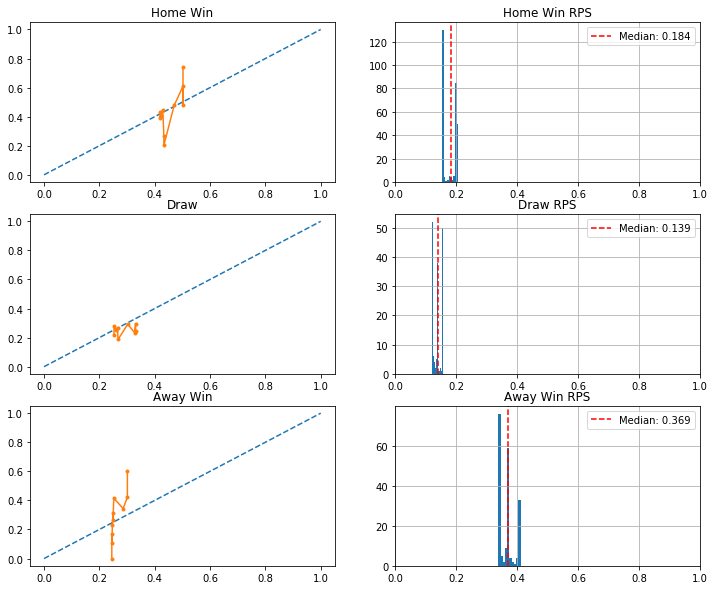


Validation Fold: 2
Average Calibration Error:  0.551
Expected Calibration Error: 0.561
Maximum Calibration Error:  0.649
Number of Instances: 644


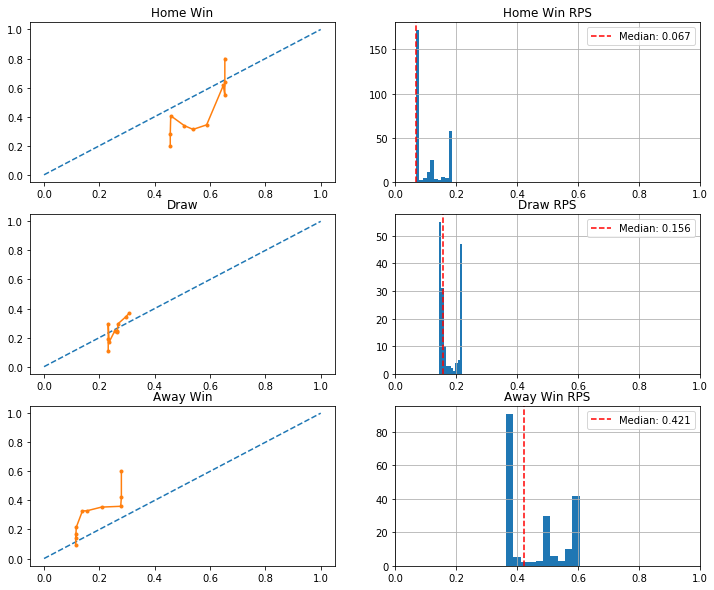


--------------------------------------------------------------------------------

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False): 1



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.459
Expected Calibration Error: 0.472
Maximum Calibration Error:  0.715
Number of Instances: 644


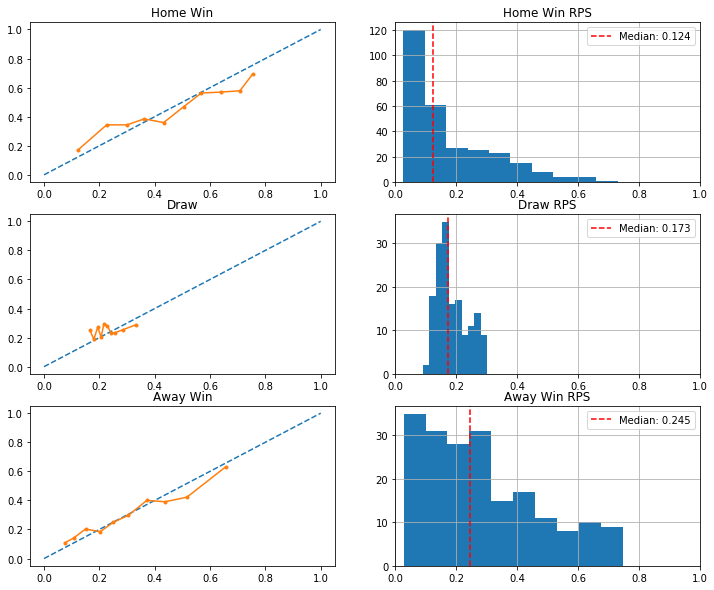


Validation Fold: 2
Average Calibration Error:  0.509
Expected Calibration Error: 0.484
Maximum Calibration Error:  0.720
Number of Instances: 644


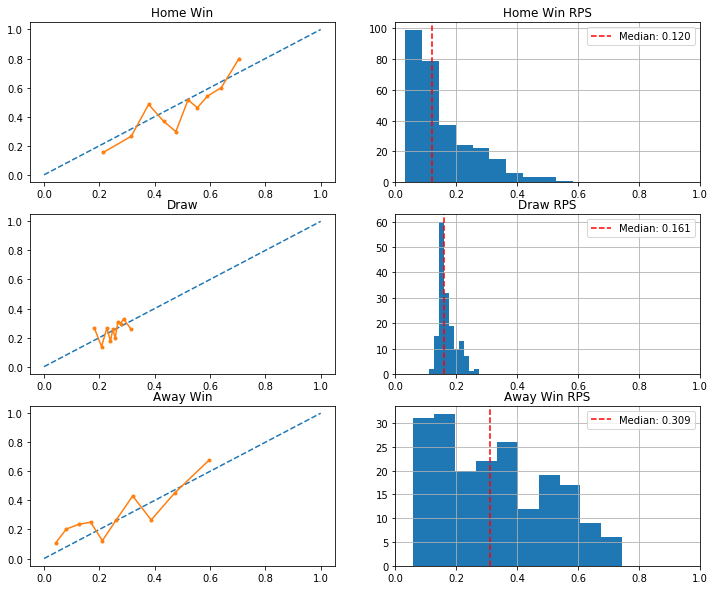


--------------------------------------------------------------------------------

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False): 2



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.527
Expected Calibration Error: 0.482
Maximum Calibration Error:  0.805
Number of Instances: 644


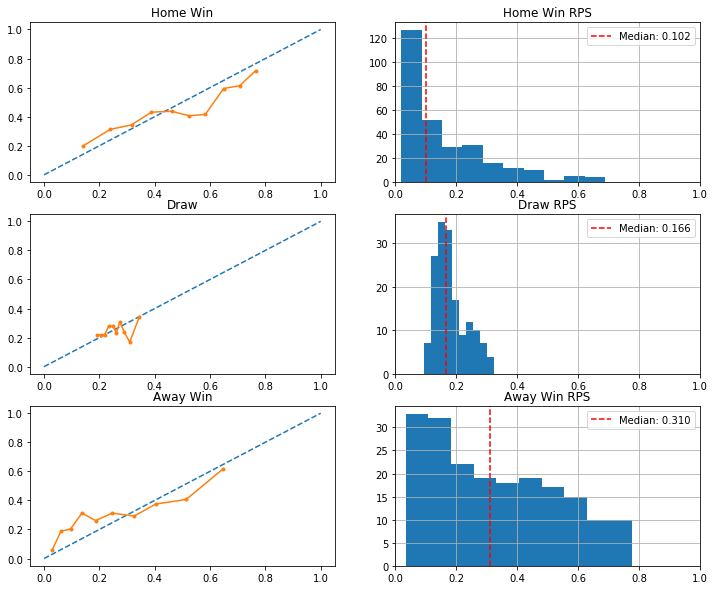


Validation Fold: 2
Average Calibration Error:  0.482
Expected Calibration Error: 0.526
Maximum Calibration Error:  0.698
Number of Instances: 644


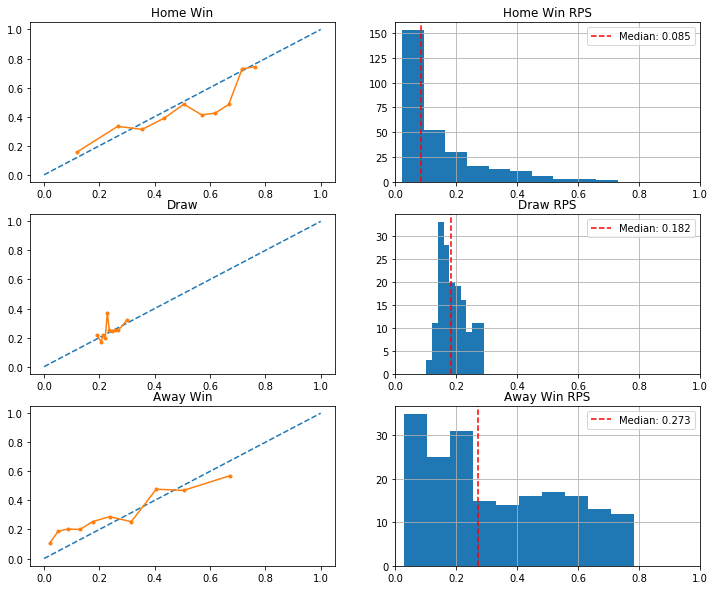


--------------------------------------------------------------------------------

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0): 3



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.375
Expected Calibration Error: 0.381
Maximum Calibration Error:  0.581
Number of Instances: 644


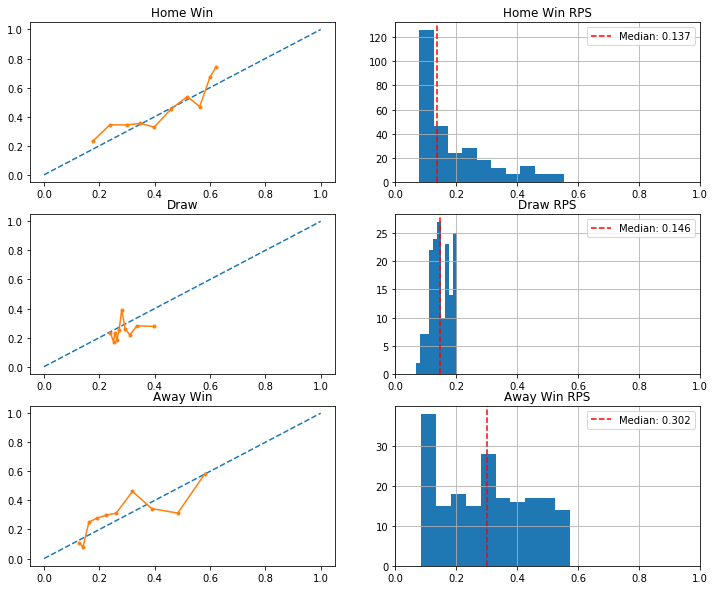


Validation Fold: 2
Average Calibration Error:  0.535
Expected Calibration Error: 0.609
Maximum Calibration Error:  0.737
Number of Instances: 644


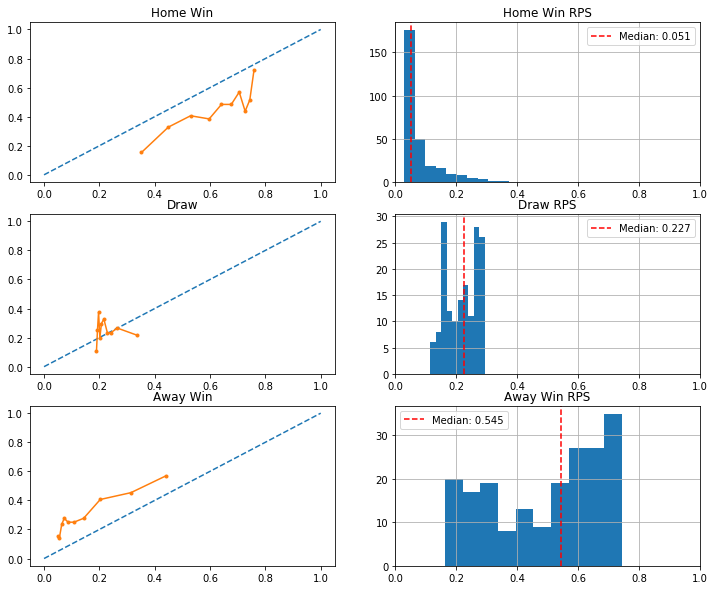


--------------------------------------------------------------------------------

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='distance'): 4



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.391
Expected Calibration Error: 0.393
Maximum Calibration Error:  0.552
Number of Instances: 644


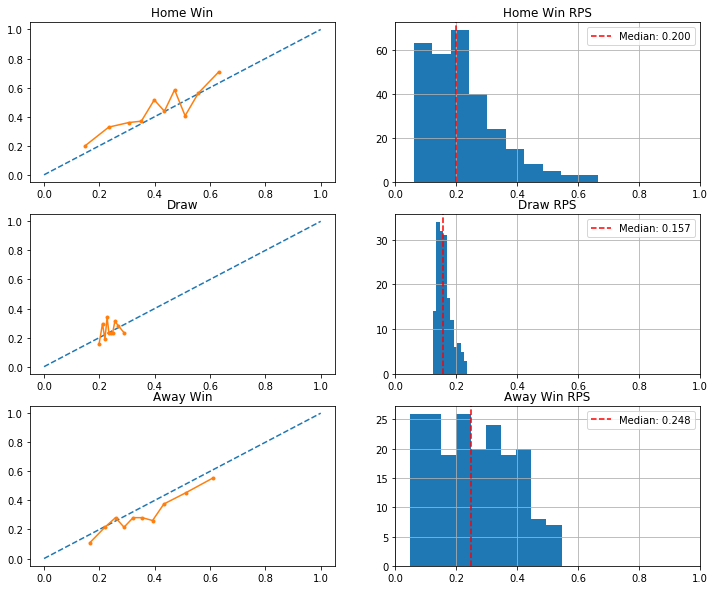


Validation Fold: 2
Average Calibration Error:  0.498
Expected Calibration Error: 0.539
Maximum Calibration Error:  0.723
Number of Instances: 644


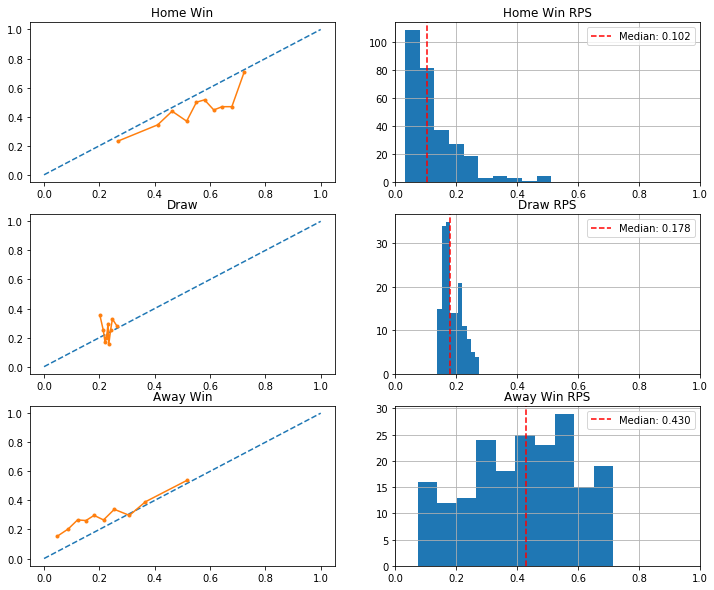


--------------------------------------------------------------------------------



In [22]:
from skoot.preprocessing import SelectiveMinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 



clfs = [GaussianNB(priors=[0.45, 0.26, 0.29]),
        RandomForestClassifier(class_weight='balanced'),
        ExtraTreesClassifier(class_weight='balanced'),
        LGBMClassifier(objective='multiclass'),
        KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='brute')]


model_dict = {}
for i, clf in enumerate(clfs):
    print(f'{clf}: {i}')
    print()
    n_splits=2
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    srs = SelectiveMinMaxScaler(trans_col_name='')
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    fitted_clf, dfs = run_fit_validate(X_train_val, y_train_val,
                                       X_cal, y_cal,
                                       meta_train_val,
                                       skf, srs, clf, sig_clf)
    # Pick up the model fitted to the last fold
    model_dict[i] = fitted_clf
    print('-'*80)
    print()

In [23]:
model_dict

{0: CalibratedClassifierCV(base_estimator=GaussianNB(priors=[0.45, 0.26, 0.29],
                                                  var_smoothing=1e-09),
                        cv='prefit', method='sigmoid'),
 1: CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              class_weight='balanced',
                                                              criterion='gini',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                      

## Best Model?

From visual inspection, I have ExtraTreesClassifier as the top, with close competition from RandomForest, LGBM, XGBoost, Logistic Regression, and Ordinal LogisticAT

In [24]:
clf = model_dict[2]
clf

CalibratedClassifierCV(base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                           ccp_alpha=0.0,
                                                           class_weight='balanced',
                                                           criterion='gini',
                                                           max_depth=None,
                                                           max_features='auto',
                                                           max_leaf_nodes=None,
                                                           max_samples=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=2,
                                                

In [25]:
joblib.dump(clf, SAMP_MODEL_FP)

['/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample/models/optimized-model.joblib']

## 8. Simulate Gambling in Test Data

In [26]:
clf = joblib.load(SAMP_MODEL_FP)
clf

CalibratedClassifierCV(base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                           ccp_alpha=0.0,
                                                           class_weight='balanced',
                                                           criterion='gini',
                                                           max_depth=None,
                                                           max_features='auto',
                                                           max_leaf_nodes=None,
                                                           max_samples=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=2,
                                                

## 8. Simulate Gambling in Test Data

In [27]:
clf = joblib.load(SAMP_MODEL_FP)
clf

CalibratedClassifierCV(base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                           ccp_alpha=0.0,
                                                           class_weight='balanced',
                                                           criterion='gini',
                                                           max_depth=None,
                                                           max_features='auto',
                                                           max_leaf_nodes=None,
                                                           max_samples=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=2,
                                                

In [28]:
def predict_on_test(X_t, y_y, meta_t, srs, sig_clf):
    meta_t = meta_held_out_test.copy(deep=True)
    X_t = X_held_out_test.copy(deep=True)
    y_t = y_held_out_test.copy(deep=True)

    meta_t.reset_index(drop=True, inplace=True)
    X_t.reset_index(drop=True, inplace=True)
    y_t.reset_index(drop=True, inplace=True)
    
    
    X_t = srs.transform(X_t)
    test_preds = sig_clf.predict_proba(X_t)
    test_preds_df = pd.DataFrame(test_preds, columns = clf.classes_)
    df_test = pd.concat([meta_t, test_preds_df], sort=False, axis=1)

    df_test['pred_class'] = df_test[[1,2, 3]].idxmax(axis=1)
    df_test['pred_result'] = df_test['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})

    df_test = insert_rps(df_test)
    df_test = insert_rps(df_test,
                             prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                             return_col_prefix='bookie')
    df_test = insert_rps(df_test,
                             prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                             return_col_prefix='baseline')
    return df_test





/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


Average Calibration Error:  0.508
Expected Calibration Error: 0.550
Maximum Calibration Error:  0.730
Number of Instances: 362


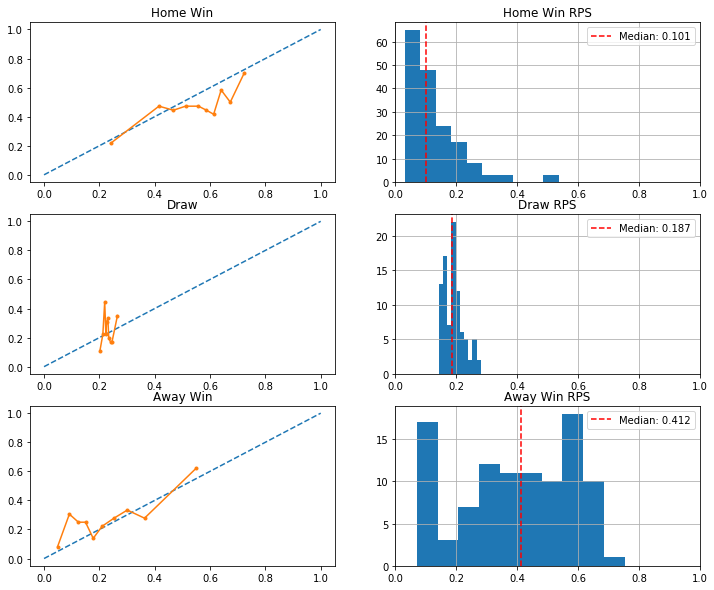

In [29]:
df = predict_on_test(X_held_out_test, y_held_out_test, meta_held_out_test, srs, sig_clf)

get_model_diagnosis(df, add_baseline=True)
plt.show();

In [30]:
df = simulate_betting(df)

df.to_csv(SAVE_FP, index=False)

df.head(15)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,1,2,3,pred_class,pred_result,model_rps,bookie_rps,baseline_rps,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,placed_bet,game_ret
0,germany,bundesliga,2016-2017,ingolstadt,rb-leipzig,2016-12-10,1.0,0.0,hwin,4.0,16.0,0.0,0.253204,0.219288,0.527508,0.154623,0.072617,0.772724,0.0,13.0,3.0,4.0,1.80,1.75,1.85,1.80,0.275,0.275,0.45,3.75,3.75,3.75,3.63,3.0,19.0,1.0,0.253204,0.527508,0.219288,0.154623,0.772724,0.072617,1.0,4.0,1.0,1.0,4.33,4.75,5.00,4.62,0.527508,0.253204,0.219288,1,1,0,0,0.405229,0.611111,0.473198,0.231347,0.295455,1,hwin,0.182407,0.443889,0.189062,1.186174,-0.160210,-0.468181,True,False,False,4.00,0.0,0.0,hwin_bet,4.00
1,germany,bundesliga,2016-2017,borussia-monchengladbach,mainz,2016-12-11,1.0,0.0,hwin,1.0,15.0,0.0,0.238367,0.570939,0.190694,0.231480,0.353203,0.415314,1.0,12.0,4.0,0.0,5.00,5.00,5.35,4.86,0.275,0.275,0.45,4.00,3.70,4.06,3.85,4.0,13.0,0.0,0.238367,0.190694,0.570939,0.231480,0.415314,0.353203,0.0,9.0,3.0,2.0,1.67,1.72,1.85,1.71,0.190694,0.238367,0.570939,1,1,0,0,0.411765,0.611111,0.666234,0.231566,0.102200,1,hwin,0.060922,0.110229,0.189062,0.139260,-0.108470,-0.503308,True,False,False,0.85,0.0,0.0,hwin_bet,0.85
2,germany,bundesliga,2016-2017,hoffenheim,dortmund,2016-12-16,2.0,2.0,draw,4.0,18.0,1.0,0.237260,0.249747,0.512994,0.227446,0.445892,0.326659,1.0,14.0,4.0,1.0,1.85,1.91,2.04,1.91,0.275,0.275,0.45,4.00,4.10,4.10,3.92,2.0,22.0,2.0,0.237260,0.512994,0.249747,0.227446,0.326659,0.445892,0.0,13.0,5.0,5.0,3.80,3.75,4.30,3.74,0.512994,0.237260,0.249747,2,0,1,0,0.415033,1.000000,0.352755,0.225244,0.422001,3,awin,0.151261,0.162768,0.139062,0.319303,-0.117045,-0.193977,True,False,False,-1.00,0.0,0.0,hwin_bet,-1.00
3,germany,bundesliga,2016-2017,schalke,sc-freiburg,2016-12-17,1.0,1.0,draw,1.0,9.0,0.0,0.238367,0.570939,0.190694,0.216683,0.621707,0.161605,0.0,6.0,2.0,0.0,5.00,5.25,5.50,5.16,0.275,0.275,0.45,4.00,4.00,4.15,3.90,9.0,12.0,0.0,0.238367,0.190694,0.570939,0.216683,0.161605,0.621707,0.0,17.0,2.0,1.0,1.67,1.65,1.77,1.67,0.190694,0.238367,0.570939,2,0,1,0,0.434641,1.000000,0.566038,0.243224,0.190738,1,hwin,0.178390,0.181168,0.139062,-0.054717,-0.051428,-0.015790,False,False,False,0.00,0.0,0.0,no_bet,0.00
4,germany,bundesliga,2016-2017,wolfsburg,eintracht-frankfurt,2016-12-17,1.0,0.0,hwin,2.0,18.0,0.0,0.298805,0.382470,0.318725,0.283842,0.165794,0.550365,0.0,7.0,1.0,4.0,3.00,2.95,3.10,2.95,0.275,0.275,0.45,3.20,3.30,3.32,3.21,4.0,17.0,1.0,0.298805,0.318725,0.382470,0.283842,0.550365,0.165794,0.0,15.0,3.0,3.0,2.50,2.45,2.67,2.50,0.318725,0.298805,0.382470,1,1,0,0,0.434641,0.611111,0.469726,0.210758,0.319516,1,hwin,0.191641,0.241464,0.189062,0.174315,-0.323467,-0.057427,True,False,False,1.67,0.0,0.0,hwin_bet,1.67
5,germany,bundesliga,2016-2017,sv-werder-bremen,fc-koln,2016-12-17,1.0,1.0,draw,5.0,17.0,1.0,0.280351,0.366613,0.353035,0.195910,0.160398,0.643674,0.0,14.0,5.0,4.0,2.70,2.70,2.78,2.70,0.275,0.275,0.45,3.40,3.30,3.52,3.33,4.0,17.0,1.0,0.280351,0.353035,0.366613,0.195910,0.643674,0.160398,0.0,10.0,5.0,1.0,2.60,2.65,2.76,2.65,0.353035,0.280351,0.366613,2,0,1,0,0.434641,1.000000,0.597435,0.206645,0.195920,1,hwin,0.197657,0.129520,0.139062,0.583202,-0.311872,-0.471015,True,False,False,-1.00,0.0,0.0,hwin_bet,-1.00
6,germany,bundesliga,2016-2017,augsburg,borussia-monchengladbach,2016-12-17,

pred hwin: 15.060000000000002 on 241 bets
pred draw: 21.060000000000002 on 50 bets
pred awin: 12.680000000000001 on 62 bets
353 bets returning 48.800000000000004 over 362 games
Overall Return: 0.138

On Sided t Test Against against Mean = 0:
	t_stat:	1.397
	p_val:	0.082


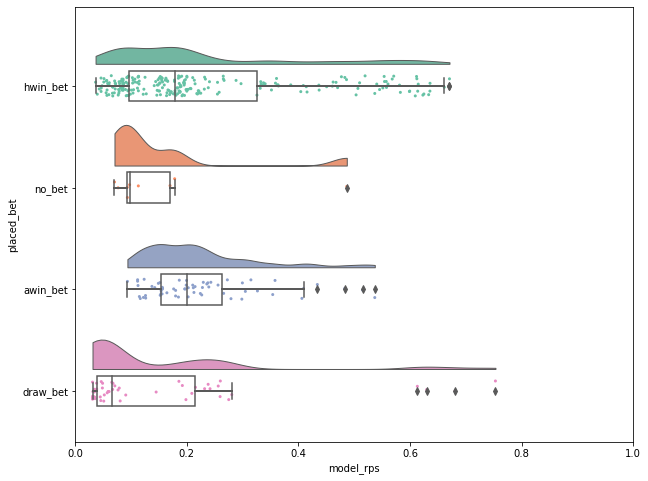

In [31]:
import ptitprince as pt
from scipy.stats import ttest_1samp

def get_betting_diagnosis(df):
    fig, ax = plt.subplots(figsize=(10,8))
    ax = pt.RainCloud(x='placed_bet', y='model_rps', data=df, width_viol=0.8, width_box=0.3,
                  orient='h', pointplot=False)
    ax.set_xlim(0.0, 1.0)
    
    bet_rets = pd.concat([df['hwin_rets'], df['draw_rets'], df['awin_rets']], axis=0)
    bet_rets = bet_rets[bet_rets != 0].values
    res = ttest_1samp(bet_rets, 0)
    t_stat = res[0]
    p_val = res[1]/2
    
    # Swarm Plot on Probabilities her
    # sns.catplot(x="day", y="total_bill", kind="swarm", data=tips);
    
    n_bets = df[["hwin_bet" , "draw_bet", "awin_bet"]].sum().sum()
    print(f'pred hwin: {df["hwin_rets"].sum()} on {df["hwin_bet"].sum()} bets')
    print(f'pred draw: {df["draw_rets"].sum()} on {df["draw_bet"].sum()} bets')
    print(f'pred awin: {df["awin_rets"].sum()} on {df["awin_bet"].sum()} bets')
    print(f'{n_bets} bets returning {df["game_ret"].sum()} over {len(df)} games')
    print(f'Overall Return: {df["game_ret"].sum()/n_bets:.3f}')
    print()
    print(f'On Sided t Test Against against Mean = 0:\n\tt_stat:\t{t_stat:.3f}\n\tp_val:\t{p_val:.3f}')
    return fig, ax


get_betting_diagnosis(df)
plt.show();

In [32]:
df[df['placed_bet'] != 'no_bet'].head(25)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,1,2,3,pred_class,pred_result,model_rps,bookie_rps,baseline_rps,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,placed_bet,game_ret
0,germany,bundesliga,2016-2017,ingolstadt,rb-leipzig,2016-12-10,1.0,0.0,hwin,4.0,16.0,0.0,0.253204,0.219288,0.527508,0.154623,0.072617,0.772724,0.0,13.0,3.0,4.0,1.80,1.75,1.85,1.80,0.275,0.275,0.45,3.75,3.75,3.75,3.63,3.0,19.0,1.0,0.253204,0.527508,0.219288,0.154623,0.772724,0.072617,1.0,4.0,1.0,1.0,4.33,4.75,5.00,4.62,0.527508,0.253204,0.219288,1,1,0,0,0.405229,0.611111,0.473198,0.231347,0.295455,1,hwin,0.182407,0.443889,0.189062,1.186174,-0.160210,-0.468181,True,False,False,4.00,0.0,0.0,hwin_bet,4.00
1,germany,bundesliga,2016-2017,borussia-monchengladbach,mainz,2016-12-11,1.0,0.0,hwin,1.0,15.0,0.0,0.238367,0.570939,0.190694,0.231480,0.353203,0.415314,1.0,12.0,4.0,0.0,5.00,5.00,5.35,4.86,0.275,0.275,0.45,4.00,3.70,4.06,3.85,4.0,13.0,0.0,0.238367,0.190694,0.570939,0.231480,0.415314,0.353203,0.0,9.0,3.0,2.0,1.67,1.72,1.85,1.71,0.190694,0.238367,0.570939,1,1,0,0,0.411765,0.611111,0.666234,0.231566,0.102200,1,hwin,0.060922,0.110229,0.189062,0.139260,-0.108470,-0.503308,True,False,False,0.85,0.0,0.0,hwin_bet,0.85
2,germany,bundesliga,2016-2017,hoffenheim,dortmund,2016-12-16,2.0,2.0,draw,4.0,18.0,1.0,0.237260,0.249747,0.512994,0.227446,0.445892,0.326659,1.0,14.0,4.0,1.0,1.85,1.91,2.04,1.91,0.275,0.275,0.45,4.00,4.10,4.10,3.92,2.0,22.0,2.0,0.237260,0.512994,0.249747,0.227446,0.326659,0.445892,0.0,13.0,5.0,5.0,3.80,3.75,4.30,3.74,0.512994,0.237260,0.249747,2,0,1,0,0.415033,1.000000,0.352755,0.225244,0.422001,3,awin,0.151261,0.162768,0.139062,0.319303,-0.117045,-0.193977,True,False,False,-1.00,0.0,0.0,hwin_bet,-1.00
4,germany,bundesliga,2016-2017,wolfsburg,eintracht-frankfurt,2016-12-17,1.0,0.0,hwin,2.0,18.0,0.0,0.298805,0.382470,0.318725,0.283842,0.165794,0.550365,0.0,7.0,1.0,4.0,3.00,2.95,3.10,2.95,0.275,0.275,0.45,3.20,3.30,3.32,3.21,4.0,17.0,1.0,0.298805,0.318725,0.382470,0.283842,0.550365,0.165794,0.0,15.0,3.0,3.0,2.50,2.45,2.67,2.50,0.318725,0.298805,0.382470,1,1,0,0,0.434641,0.611111,0.469726,0.210758,0.319516,1,hwin,0.191641,0.241464,0.189062,0.174315,-0.323467,-0.057427,True,False,False,1.67,0.0,0.0,hwin_bet,1.67
5,germany,bundesliga,2016-2017,sv-werder-bremen,fc-koln,2016-12-17,1.0,1.0,draw,5.0,17.0,1.0,0.280351,0.366613,0.353035,0.195910,0.160398,0.643674,0.0,14.0,5.0,4.0,2.70,2.70,2.78,2.70,0.275,0.275,0.45,3.40,3.30,3.52,3.33,4.0,17.0,1.0,0.280351,0.353035,0.366613,0.195910,0.643674,0.160398,0.0,10.0,5.0,1.0,2.60,2.65,2.76,2.65,0.353035,0.280351,0.366613,2,0,1,0,0.434641,1.000000,0.597435,0.206645,0.195920,1,hwin,0.197657,0.129520,0.139062,0.583202,-0.311872,-0.471015,True,False,False,-1.00,0.0,0.0,hwin_bet,-1.00
6,germany,bundesliga,2016-2017,augsburg,borussia-monchengladbach,2016-12-17,1.0,0.0,hwin,0.0,12.0,0.0,0.306709,0.297125,0.396166,0.347111,0.372500,0.280389,0.0,8.0,3.0,0.0,2.40,2.40,2.60,2.44,0.275,0.275,0.45,3.10,3.40,3.40,3.24,3.0,16.0,0.0,0.306709,0.396166,0.297125,0.347111,0.280389,0.372500,0.0,8.0,1.0,0.0,3.20,2.95,3.20,3.03,0.396166,0.306709,0.297125,1,1,0,0,0.434641,0.611111,0.573020,0.268005,0.158975,1,hwin,0.103792,0.325491,0.189062,0.736251,-0.131663,-0.612102,True,False,False,2.20,0.0,0.0,hwin_bet,2.20
7,germany,bundesliga,2016-2017,rb-leipzig,hertha-berlin,2016-1

In [33]:
df[df['placed_bet'] != 'no_bet'].tail(25)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,1,2,3,pred_class,pred_result,model_rps,bookie_rps,baseline_rps,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,placed_bet,game_ret
336,germany,bundesliga,2017-2018,bayern-munich,eintracht-frankfurt,2018-04-28,4.0,1.0,hwin,2.0,9.0,0.0,0.220701,0.597273,0.182026,0.104790,0.847780,0.047154,0.0,12.0,3.0,0.0,5.25,5.25,5.84,5.19,0.275,0.275,0.45,4.33,4.20,4.33,4.13,1.0,6.0,1.0,0.220701,0.182026,0.597273,0.104790,0.047154,0.847780,0.0,12.0,6.0,0.0,1.60,1.62,1.70,1.63,0.182026,0.220701,0.597273,1,1,0,0,0.934641,0.611111,0.731960,0.229096,0.038944,1,hwin,0.036681,0.097661,0.189062,0.193095,-0.053832,-0.797883,True,False,False,0.70,0.0,0.0,hwin_bet,0.70
337,germany,bundesliga,2017-2018,hertha-berlin,augsburg,2018-04-28,2.0,2.0,draw,3.0,14.0,1.0,0.289800,0.461691,0.248509,0.282686,0.465670,0.251644,1.0,12.0,3.0,2.0,3.79,3.60,3.80,3.60,0.275,0.275,0.45,3.25,3.30,3.58,3.39,6.0,9.0,0.0,0.289800,0.248509,0.461691,0.282686,0.251644,0.465670,0.0,8.0,5.0,0.0,2.04,2.15,2.17,2.09,0.248509,0.289800,0.461691,2,0,1,0,0.934641,1.000000,0.476357,0.231029,0.292613,1,hwin,0.156269,0.137458,0.139062,-0.004413,-0.216811,0.053407,False,False,True,0.00,0.0,-1.0,awin_bet,-1.00
338,germany,bundesliga,2017-2018,leverkusen,stuttgart,2018-04-28,0.0,1.0,awin,2.0,12.0,0.0,0.199560,0.681951,0.118489,0.229487,0.614937,0.155573,0.0,4.0,1.0,0.0,8.00,7.50,8.30,7.50,0.275,0.275,0.45,4.75,4.75,5.09,4.78,6.0,13.0,0.0,0.199560,0.118489,0.681951,0.229487,0.155573,0.614937,0.0,24.0,7.0,2.0,1.39,1.42,1.45,1.41,0.118489,0.199560,0.681951,3,0,0,1,0.934641,1.000000,0.505464,0.245022,0.249514,1,hwin,0.409361,0.621059,0.364063,-0.287296,0.171204,0.871357,False,False,True,0.00,0.0,7.3,awin_bet,7.30
339,germany,bundesliga,2017-2018,sc-freiburg,fc-koln,2018-04-28,3.0,2.0,hwin,5.0,13.0,0.0,0.281219,0.453967,0.264814,0.269999,0.461164,0.268837,0.0,13.0,3.0,4.0,3.60,3.60,3.70,3.54,0.275,0.275,0.45,3.39,3.50,3.63,3.42,2.0,16.0,1.0,0.281219,0.264814,0.453967,0.269999,0.268837,0.461164,0.0,12.0,6.0,2.0,2.10,2.05,2.20,2.11,0.264814,0.281219,0.453967,1,1,0,0,0.934641,0.611111,0.595552,0.252749,0.151699,1,hwin,0.093295,0.184139,0.189062,0.256616,-0.135600,-0.462986,True,False,False,1.20,0.0,0.0,hwin_bet,1.20
340,germany,bundesliga,2017-2018,schalke,borussia-monchengladbach,2018-04-28,1.0,1.0,draw,1.0,11.0,1.0,0.262944,0.511675,0.225381,0.208753,0.618460,0.172778,0.0,10.0,4.0,4.0,4.20,4.33,4.49,4.21,0.275,0.275,0.45,3.60,3.50,3.82,3.65,1.0,11.0,1.0,0.262944,0.225381,0.511675,0.208753,0.172778,0.618460,1.0,10.0,4.0,2.0,1.85,1.87,1.91,1.86,0.225381,0.262944,0.511675,2,0,1,0,0.934641,1.000000,0.621779,0.260498,0.117723,1,hwin,0.200234,0.156304,0.139062,0.156509,-0.049181,-0.504387,True,False,False,-1.00,0.0,0.0,hwin_bet,-1.00
341,germany,bundesliga,2017-2018,wolfsburg,hamburger-sv,2018-04-28,1.0,3.0,awin,6.0,17.0,2.0,0.280010,0.431470,0.288521,0.299944,0.519734,0.180322,0.0,14.0,5.0,2.0,3.29,3.50,3.60,3.38,0.275,0.275,0.45,3.39,3.25,3.50,3.28,2.0,14.0,0.0,0.280010,0.288521,0.431470,0.299944,0.180322,0.519734,0.0,10.0,1.0,3.0,2.20,2.20,2.32,2.23,0.288521,0.280010,0.431470,3,0,0,1,0.934641,1.000000,0.543491,0.256413,0.200096,1,hwin,0.467615,0.346184,0.364063,0.211986,-0.158967,-0.323676,True,False,False,-1.00,0.0,0.0,hwin_bet,-1.00
342,germany,bundesliga,2017-2018,mainz,rb-leipzig,2018-04